In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing 


In [2]:


df = pd.read_csv('uber.csv')

df.head()
df.describe()


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [3]:
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


cleaning

In [5]:
df.isna().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

remove null rows 

In [6]:
df.dropna(axis=0,inplace=True)

In [7]:
incorrect_coordinates = df.loc[
(df.pickup_latitude > 90) |(df.pickup_latitude < -90) |
(df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) |
(df.pickup_longitude > 180) |(df.pickup_longitude < -180) |
(df.dropoff_longitude > 90) |(df.dropoff_longitude < -90)
]
df.drop(incorrect_coordinates, inplace = True, errors = 'ignore')


In [8]:
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    long1, lati1, long2, lati2 = map(np.radians, [longitude1, latitude1, longitude2, latitude2])
    dist_long = long2 - long1
    dist_lati = lati2 - lati1
    a = np.sin(dist_lati/2)**2 + np.cos(lati1) * np.cos(lati2) * np.sin(dist_long/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) * 6371
    return c

In [9]:
df['Distance'] = distance_transform(
df['pickup_longitude'],
df['pickup_latitude'],
df['dropoff_longitude'],
df['dropoff_latitude']
)

Text(0, 0.5, 'fare_amount')

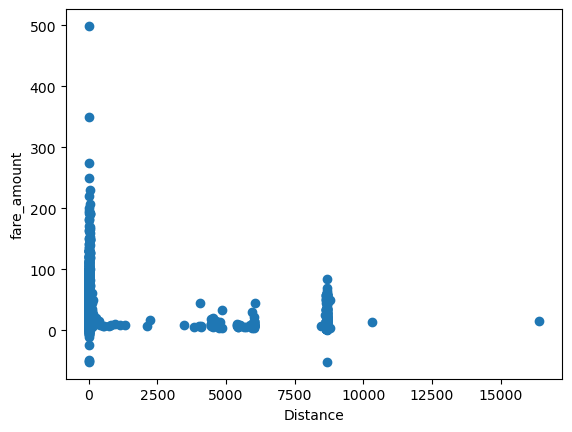

In [10]:
plt.scatter(df['Distance'], df['fare_amount'])
plt.xlabel("Distance")
plt.ylabel("fare_amount")

In [11]:
df.drop(df[df['Distance'] >=60].index, inplace = True)
df.drop(df[df['fare_amount']  <=0].index, inplace = True)
df.drop(df[(df['fare_amount']>100) & (df['Distance']<1)].index, inplace = True )
df.drop(df[(df['fare_amount']<100) & (df['Distance']>100)].index, inplace = True )


[[-0.39820843]
 [-0.37738556]
 [ 0.1640092 ]
 ...
 [ 2.03806797]
 [ 0.3305922 ]
 [ 0.28894645]]
[[-0.43819769]
 [-0.22258873]
 [ 0.49552213]
 ...
 [ 2.67145829]
 [ 0.07874908]
 [ 0.60173174]]


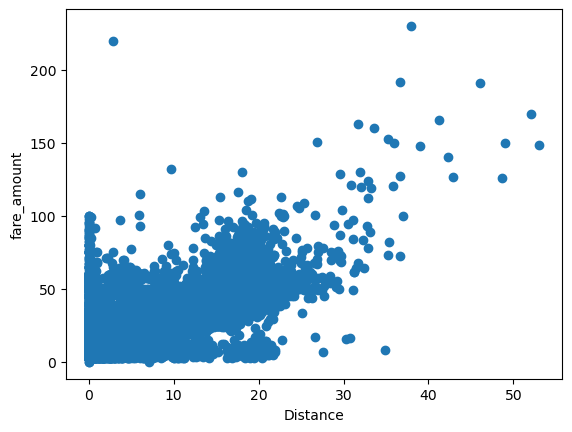

In [12]:
plt.scatter(df['Distance'], df['fare_amount'])
plt.xlabel("Distance")
plt.ylabel("fare_amount")

X = df['Distance'].values.reshape(-1, 1)
#Independent Variable
y = df['fare_amount'].values.reshape(-1, 1)
#Dependent VariableIn [ ]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
y_std = std.fit_transform(y)
print(y_std)
x_std = std.fit_transform(X)
print(x_std)


In [13]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\hp\AppData\Local\Temp\ipykernel_23604\3784545759.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance
Unnamed: 0,1.000000,0.000431,0.000324,-0.000725,0.000337,-0.000269,0.002159,-0.000900
fare_amount,0.000431,1.000000,0.005885,-0.006253,0.005501,-0.006142,0.011693,0.857729
pickup_longitude,0.000324,0.005885,1.000000,-0.973204,0.999992,-0.981941,-0.000649,-0.117044
pickup_latitude,-0.000725,-0.006253,-0.973204,1.000000,-0.973206,0.991076,-0.001190,0.110843
dropoff_longitude,0.000337,0.005501,0.999992,-0.973206,1.000000,-0.981942,-0.000650,-0.117282
dropoff_latitude,-0.000269,-0.006142,-0.981941,0.991076,-0.981942,1.000000,-0.001035,0.109486
passenger_count,0.002159,0.011693,-0.000649,-0.001190,-0.000650,-0.001035,1.000000,0.007784
Distance,-0.000900,0.857729,-0.117044,0.110843,-0.117282,0.109486,0.007784,1.000000


Standardization

In [14]:
X = df['Distance'].values.reshape(-1, 1)#RESHAPE FOR SINGLE SAMPLE
#Independent Variable
y = df['fare_amount'].values.reshape(-1, 1)
#Dependent VariableIn [ ]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
y_std = std.fit_transform(y)
print(y_std)
x_std = std.fit_transform(X)
print(x_std)


[[-0.39820843]
 [-0.37738556]
 [ 0.1640092 ]
 ...
 [ 2.03806797]
 [ 0.3305922 ]
 [ 0.28894645]]
[[-0.43819769]
 [-0.22258873]
 [ 0.49552213]
 ...
 [ 2.67145829]
 [ 0.07874908]
 [ 0.60173174]]


Training and Test Set



In [15]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_std, y_std, test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
l_reg = LinearRegression()
l_reg.fit(X_train, y_train)
print("Training set score: {:.2f}".format(l_reg.score(X_train, y_train)))
print("Test set score: {:.7f}".format(l_reg.score(X_test, y_test)))

Training set score: 0.74
Test set score: 0.7340468


In [16]:
y_pred = l_reg.predict(X_test)
result = pd.DataFrame()
result[['Actual']] = y_test
result[['Predicted']] = y_pred
result.sample(10)

,Actual,Predicted
13786,-0.710552,-0.627422
5012,-0.502323,-0.621533
13707,0.486764,0.630180
21939,-0.658494,-0.490091
30722,0.039072,0.633175
8324,-0.210803,-0.076604
2461,-0.502323,-0.409738
13313,0.486764,0.639997
36226,-0.543969,-0.432334
34378,-0.502323,-0.470208


In [17]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Absolute % Error:', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R Squared (R²):', np.sqrt(metrics.r2_score(y_test, y_pred)))


Mean Absolute Error: 0.26621298757938944
Mean Absolute % Error: 1.98307476334074
Mean Squared Error: 0.27052435107785416
Root Mean Squared Error: 0.5201195546005304
R Squared (R²): 0.8567653080822022


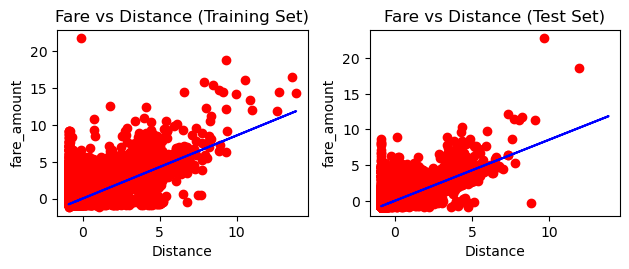

In [18]:
plt.subplot(2, 2, 1)
plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_train, l_reg.predict(X_train), color ="blue")
plt.title("Fare vs Distance (Training Set)")
plt.ylabel("fare_amount")
plt.xlabel("Distance")
plt.subplot(2, 2, 2)
plt.scatter(X_test, y_test, color = 'red')
plt.plot(X_train, l_reg.predict(X_train), color ="blue")
plt.ylabel("fare_amount")
plt.xlabel("Distance")
plt.title("Fare vs Distance (Test Set)")
plt.tight_layout()
plt.show()

In [19]:

cols = ['Model', 'RMSE', 'R-Squared']
# create a empty dataframe of the colums
# columns: specifies the columns to be selected
result_tabulation = pd.DataFrame(columns = cols)
# compile the required information
linreg_metrics = pd.DataFrame([[
"Linear Regresion model",
np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
np.sqrt(metrics.r2_score(y_test, y_pred))
]], columns = cols)
result_tabulation = pd.concat([result_tabulation, linreg_metrics], ignore_index=True)



In [20]:
result_tabulation

,Model,RMSE,R-Squared
0,Linear Regresion model,0.52012,0.856765


In [21]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=10)
# fit the regressor with training dataset
rf_reg.fit(X_train, y_train)

c:\Users\hp\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=10)

In [22]:
# predict the values on test dataset using predict()
y_pred_RF = rf_reg.predict(X_test)
result = pd.DataFrame()
result[['Actual']] = y_test
result['Predicted'] = y_pred_RF
result.sample(10)


,Actual,Predicted
35567,-0.762609,-0.565624
1887,0.288946,0.434707
12034,-0.450266,-0.583636
8398,-0.335740,-0.164680
6865,-0.460677,-0.164784
27913,-0.460677,-0.055464
7175,-0.668906,-0.492744
37395,1.246799,-0.020017
36422,0.226478,-0.394981
18067,-0.210803,-0.451203


In [23]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_RF))
print('Mean Absolute % Error:', metrics.mean_absolute_percentage_error(y_test, y_pred_RF))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_RF))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)))
print('R Squared (R²):', np.sqrt(metrics.r2_score(y_test, y_pred_RF)))

Mean Absolute Error: 0.3077087698385678
Mean Absolute % Error: 2.161623761570947
Mean Squared Error: 0.33297733033643484
Root Mean Squared Error: 0.5770418791876677
R Squared (R²): 0.8201518783882692


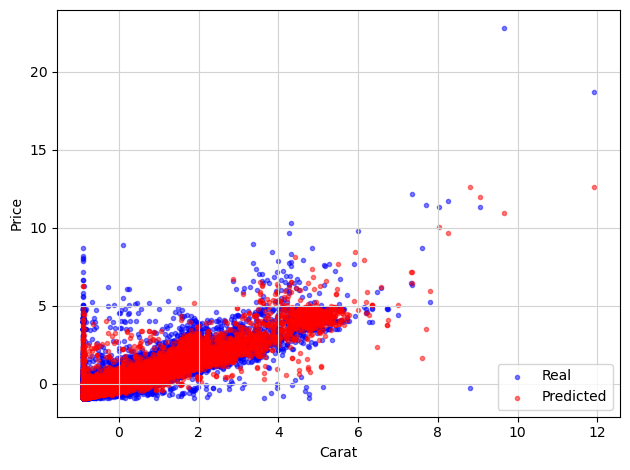

In [24]:
# Build scatterplot
plt.scatter(X_test, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(X_test, y_pred_RF, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()

In [25]:
random_forest_metrics = pd.DataFrame([[
"Random Forest Regressor model",
np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)),
np.sqrt(metrics.r2_score(y_test, y_pred_RF))
]], columns = cols)
result_tabulation = pd.concat([result_tabulation, random_forest_metrics], ignore_index=True)
result_tabulation


,Model,RMSE,R-Squared
0,Linear Regresion model,0.520120,0.856765
1,Random Forest Regressor model,0.577042,0.820152
